In [1]:
import os

from dotenv import load_dotenv

load_dotenv(os.path.join("..", ".env"), override=True)

%load_ext autoreload
%autoreload 2

# Deep Agent for Research

## Overview 

<img src="./assets/agent_header.png" width="800" style="display:block; margin-left:0;">

Now, we can put everything we have learned together:

* We will use **TODOs** to keep track of tasks. 
* We will use **files** to store raw tool call results. 
* We will **delegate research tasks to sub-agents** for context isolation. 

## Search Tool 

We'll build a search tool that offloads raw contents to files and returns only a summary to the agent. This is a common pattern for long-running agent trajectories, [as we've seen with Manus](https://manus.im/blog/Context-Engineering-for-AI-Agents-Lessons-from-Building-Manus)! 

### Core Components

1. **Search Execution (`run_tavily_search`)**: Performs the actual web search using Tavily API with configurable parameters for results count and topic filtering.

2. **Content Summarization (`summarize_webpage_content`)**: Uses a lightweight model (GPT-4o-mini) to generate structured summaries of webpage content, producing both a descriptive filename and key learnings summary.

3. **Result Processing (`process_search_results`)**: Fetches full webpage content via HTTP, converts HTML to markdown using `markdownify`, and generates summaries for each result.

4. **Context Offloading (`tavily_search` tool)**: The main tool that:
   - Executes search and processes results
   - Saves full content to files in agent state (context offloading)
   - Returns only minimal summaries to the agent (prevents context spam)
   - Uses LangGraph `Command` to update both files and messages

5. **Strategic Thinking (`think_tool`)**: Provides a structured reflection mechanism for agents to analyze findings, assess gaps, and plan next steps in their research workflow.

This architecture solves the token efficiency problem by storing detailed search results in files while keeping the agent's working context minimal and focused.

In [2]:
%%writefile ../src/deep_agents_from_scratch/research_tools.py
"""Research Tools.

This module provides search and content processing utilities for the research agent,
including web search capabilities and content summarization tools.
"""
import os
from datetime import datetime
import uuid, base64

import httpx
from langchain.chat_models import init_chat_model
from langchain_core.messages import HumanMessage, ToolMessage
from langchain_core.tools import InjectedToolArg, InjectedToolCallId, tool
from langgraph.prebuilt import InjectedState
from langgraph.types import Command
from markdownify import markdownify
from pydantic import BaseModel, Field
from tavily import TavilyClient
from typing_extensions import Annotated, Literal

from deep_agents_from_scratch.prompts import SUMMARIZE_WEB_SEARCH
from deep_agents_from_scratch.state import DeepAgentState

# Summarization model 
summarization_model = init_chat_model(model="openai:gpt-4o-mini")
tavily_client = TavilyClient()

class Summary(BaseModel):
    """Schema for webpage content summarization."""
    filename: str = Field(description="Name of the file to store.")
    summary: str = Field(description="Key learnings from the webpage.")

def get_today_str() -> str:
    """Get current date in a human-readable format."""
    return datetime.now().strftime("%a %b %-d, %Y")

def run_tavily_search(
    search_query: str, 
    max_results: int = 1, 
    topic: Literal["general", "news", "finance"] = "general", 
    include_raw_content: bool = True, 
) -> dict:
    """Perform search using Tavily API for a single query.

    Args:
        search_query: Search query to execute
        max_results: Maximum number of results per query
        topic: Topic filter for search results
        include_raw_content: Whether to include raw webpage content

    Returns:
        Search results dictionary
    """
    result = tavily_client.search(
        search_query,
        max_results=max_results,
        include_raw_content=include_raw_content,
        topic=topic
    )

    return result

def summarize_webpage_content(webpage_content: str) -> Summary:
    """Summarize webpage content using the configured summarization model.
    
    Args:
        webpage_content: Raw webpage content to summarize
        
    Returns:
        Summary object with filename and summary
    """
    try:
        # Set up structured output model for summarization
        structured_model = summarization_model.with_structured_output(Summary)
        
        # Generate summary
        summary_and_filename = structured_model.invoke([
            HumanMessage(content=SUMMARIZE_WEB_SEARCH.format(
                webpage_content=webpage_content, 
                date=get_today_str()
            ))
        ])
        
        return summary_and_filename
        
    except Exception:
        # Return a basic summary object on failure
        return Summary(
            filename="search_result.md",
            summary=webpage_content[:1000] + "..." if len(webpage_content) > 1000 else webpage_content
        )

def process_search_results(results: dict) -> list[dict]:
    """Process search results by summarizing content where available.
    
    Args:
        results: Tavily search results dictionary
        
    Returns:
        List of processed results with summaries
    """
    processed_results = []

    # Create a client for HTTP requests
    HTTPX_CLIENT = httpx.Client()
    
    for result in results.get('results', []):
        
        # Get url 
        url = result['url']
        
        # Read url
        response = HTTPX_CLIENT.get(url)

        if response.status_code == 200:
            # Convert HTML to markdown
            raw_content = markdownify(response.text)
            summary_obj = summarize_webpage_content(raw_content)
        else:
            # Use Tavily's generated summary
            raw_content = result.get('raw_content', '')
            summary_obj = Summary(
                filename="URL_error.md",
                summary=result.get('content', 'Error reading URL; try another search.')
            )
        
        # uniquify file names
        uid = base64.urlsafe_b64encode(uuid.uuid4().bytes).rstrip(b"=").decode("ascii")[:8]
        name, ext = os.path.splitext(summary_obj.filename)
        summary_obj.filename = f"{name}_{uid}{ext}"

        processed_results.append({
            'url': result['url'],
            'title': result['title'],
            'summary': summary_obj.summary,
            'filename': summary_obj.filename,
            'raw_content': raw_content,
        })
    
    return processed_results

@tool(parse_docstring=True)
def tavily_search(
    query: str,
    state: Annotated[DeepAgentState, InjectedState],
    tool_call_id: Annotated[str, InjectedToolCallId],
    max_results: Annotated[int, InjectedToolArg] = 1,
    topic: Annotated[Literal["general", "news", "finance"], InjectedToolArg] = "general",
) -> Command:
    """Search web and save detailed results to files while returning minimal context.

    Performs web search and saves full content to files for context offloading.
    Returns only essential information to help the agent decide on next steps.

    Args:
        query: Search query to execute
        state: Injected agent state for file storage
        tool_call_id: Injected tool call identifier
        max_results: Maximum number of results to return (default: 1)
        topic: Topic filter - 'general', 'news', or 'finance' (default: 'general')

    Returns:
        Command that saves full results to files and provides minimal summary
    """
    # Execute search
    search_results = run_tavily_search(
        query,
        max_results=max_results,
        topic=topic,
        include_raw_content=True,
    ) 

    # Process and summarize results
    processed_results = process_search_results(search_results)
    
    # Save each result to a file and prepare summary
    files = state.get("files", {})
    saved_files = []
    summaries = []
    
    for i, result in enumerate(processed_results):
        # Use the AI-generated filename from summarization
        filename = result['filename']
        
        # Create file content with full details
        file_content = f"""# Search Result: {result['title']}

**URL:** {result['url']}
**Query:** {query}
**Date:** {get_today_str()}

## Summary
{result['summary']}

## Raw Content
{result['raw_content'] if result['raw_content'] else 'No raw content available'}
"""
        
        files[filename] = file_content
        saved_files.append(filename)
        summaries.append(f"- {filename}: {result['summary']}...")
    
    # Create minimal summary for tool message - focus on what was collected
    summary_text = f"""🔍 Found {len(processed_results)} result(s) for '{query}':

{chr(10).join(summaries)}

Files: {', '.join(saved_files)}
💡 Use read_file() to access full details when needed."""

    return Command(
        update={
            "files": files,
            "messages": [
                ToolMessage(summary_text, tool_call_id=tool_call_id)
            ],
        }
    )

@tool(parse_docstring=True)
def think_tool(reflection: str) -> str:
    """Tool for strategic reflection on research progress and decision-making.

    Use this tool after each search to analyze results and plan next steps systematically.
    This creates a deliberate pause in the research workflow for quality decision-making.

    When to use:
    - After receiving search results: What key information did I find?
    - Before deciding next steps: Do I have enough to answer comprehensively?
    - When assessing research gaps: What specific information am I still missing?
    - Before concluding research: Can I provide a complete answer now?
    - How complex is the question: Have I reached the number of search limits?

    Reflection should address:
    1. Analysis of current findings - What concrete information have I gathered?
    2. Gap assessment - What crucial information is still missing?
    3. Quality evaluation - Do I have sufficient evidence/examples for a good answer?
    4. Strategic decision - Should I continue searching or provide my answer?

    Args:
        reflection: Your detailed reflection on research progress, findings, gaps, and next steps

    Returns:
        Confirmation that reflection was recorded for decision-making
    """
    return f"Reflection recorded: {reflection}"

Overwriting ../src/deep_agents_from_scratch/research_tools.py


## Deep Agent

Now, we can just apply all of our prior learnings: 

* We'll give the researcher a `think_tool` and our `search_tool` above.
* We'll give our parent agent file tools, a `think_tool`, and a `task` tool. 

In [3]:
from datetime import datetime

from IPython.display import Image, display
from langchain.chat_models import init_chat_model
from langgraph.prebuilt import create_react_agent
from utils import show_prompt, stream_agent

from deep_agents_from_scratch.file_tools import ls, read_file, write_file
from deep_agents_from_scratch.prompts import (
    FILE_USAGE_INSTRUCTIONS,
    RESEARCHER_INSTRUCTIONS,
    SUBAGENT_USAGE_INSTRUCTIONS,
    TODO_USAGE_INSTRUCTIONS,
)
from deep_agents_from_scratch.research_tools import tavily_search, think_tool, get_today_str
from deep_agents_from_scratch.state import DeepAgentState
from deep_agents_from_scratch.task_tool import _create_task_tool
from deep_agents_from_scratch.todo_tools import write_todos, read_todos

# Create agent using create_react_agent directly
model = init_chat_model(model="anthropic:claude-sonnet-4-20250514", temperature=0.0)

# Limits
max_concurrent_research_units = 3
max_researcher_iterations = 3

# Tools
sub_agent_tools = [tavily_search, think_tool]
built_in_tools = [ls, read_file, write_file, write_todos, read_todos, think_tool]

# Create research sub-agent
research_sub_agent = {
    "name": "research-agent",
    "description": "Delegate research to the sub-agent researcher. Only give this researcher one topic at a time.",
    "prompt": RESEARCHER_INSTRUCTIONS.format(date=get_today_str()),
    "tools": ["tavily_search", "think_tool"],
}

# Create task tool to delegate tasks to sub-agents
task_tool = _create_task_tool(
    sub_agent_tools, [research_sub_agent], model, DeepAgentState
)

delegation_tools = [task_tool]
all_tools = sub_agent_tools + built_in_tools + delegation_tools  # search available to main agent for trivial cases

# Build prompt
SUBAGENT_INSTRUCTIONS = SUBAGENT_USAGE_INSTRUCTIONS.format(
    max_concurrent_research_units=max_concurrent_research_units,
    max_researcher_iterations=max_researcher_iterations,
    date=datetime.now().strftime("%a %b %-d, %Y"),
)

In [4]:
show_prompt(RESEARCHER_INSTRUCTIONS)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  You are a research assistant conducting research on the user's input topic. For context, today's date is       │
│  {date}.                                                                                                        │
│                                                                                                                 │
│  <Task>                                                                                                         │
│  Your job is to use tools to gather information about the user's input topic.                                   │
│  You can use any of the tools provided to you to find resources that can help answer the research question.     │
│  You can call these tools in series or in parallel, your research is conducted in a tool-calling loop.          │
│  </Task>                                                                                                        │
│                                                                                                                 │
│  <Available Tools>                                                                                              │
│  You have access to two main tools:                                                                             │
│  1. **tavily_search**: For conducting web searches to gather information                                        │
│  2. **think_tool**: For reflection and strategic planning during research                                       │
│                                                                                                                 │
│  **CRITICAL: Use think_tool after each search to reflect on results and plan next steps**                       │
│  </Available Tools>                                                                                             │
│                                                                                                                 │
│  <Instructions>                                                                                                 │
│  Think like a human researcher with limited time. Follow these steps:                                           │
│                                                                                                                 │
│  1. **Read the question carefully** - What specific information does the user need?                             │
│  2. **Start with broader searches** - Use broad, comprehensive queries first                                    │
│  3. **After each search, pause and assess** - Do I have enough to answer? What's still missing?                 │
│  4. **Execute narrower searches as you gather information** - Fill in the gaps                                  │
│  5. **Stop when you can answer confidently** - Don't keep searching for perfection                              │
│  </Instructions>                                                                                                │
│                                                                                                                 │
│  <Hard Limits>                                                                                                  │
│  **Tool Call Budgets** (Prevent excessive searching):                                                           │
│  - **Simple queries**: Use 1-2 search tool calls maximum                                                        │
│  - **Normal queries**: Use 2-3 search tool calls maximum                                                        │
│  - **Very Complex queries**: Use up to 5 search tool calls maximum                                              │
│  - **Always stop**: After 5 search tool calls if you c

In [5]:
INSTRUCTIONS = (
    "# TODO MANAGEMENT\n"
    + TODO_USAGE_INSTRUCTIONS
    + "\n\n"
    + "=" * 80
    + "\n\n"
    + "# FILE SYSTEM USAGE\n"
    + FILE_USAGE_INSTRUCTIONS
    + "\n\n"
    + "=" * 80
    + "\n\n"
    + "# SUB-AGENT DELEGATION\n"
    + SUBAGENT_INSTRUCTIONS
)

show_prompt(INSTRUCTIONS)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  # TODO MANAGEMENT                                                                                              │
│  Based upon the user's request:                                                                                 │
│  1. Use the write_todos tool to create TODO at the start of a user request, per the tool description.           │
│  2. After you accomplish a TODO, use the read_todos to read the TODOs in order to remind yourself of the plan.  │
│  3. Reflect on what you've done and the TODO.                                                                   │
│  4. Mark you task as completed, and proceed to the next TODO.                                                   │
│  5. Continue this process until you have completed all TODOs.                                                   │
│                                                                                                                 │
│  IMPORTANT: Always create a research plan of TODOs and conduct research following the above guidelines for ANY  │
│  user request.                                                                                                  │
│  IMPORTANT: Aim to batch research tasks into a *single TODO* in order to minimize the number of TODOs you have  │
│  to keep track of.                                                                                              │
│                                                                                                                 │
│                                                                                                                 │
│  ================================================================================                               │
│                                                                                                                 │
│  # FILE SYSTEM USAGE                                                                                            │
│  You have access to a virtual file system to help you retain and save context.                                  │
│                                                                                                                 │
│  ## Workflow Process                                                                                            │
│  1. **Orient**: Use ls() to see existing files before starting work                                             │
│  2. **Save**: Use write_file() to store the user's request so that we can keep it for later                     │
│  3. **Research**: Proceed with research. The search tool will write files.                                      │
│  4. **Read**: Once you are satisfied with the collected sources, read the files and use them to answer the      │
│  user's question directly.                                                                                      │
│                                                                                                                 │
│                                                                                                                 │
│  ================================================================================                               │
│                                                                                                                 │
│  # SUB-AGENT DELEGATION                                                                                         │
│  You can delegate tasks to sub-agents.                                                                          │
│                                                                                                                 │
│  <Task>                                               

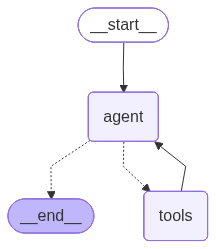

In [6]:
# Create agent
agent = create_react_agent(
    model, all_tools, prompt=INSTRUCTIONS, state_schema=DeepAgentState
)

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [7]:
from utils import format_messages

result = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "Give me an overview of Model Context Protocol (MCP).",
            }
        ],
    }
)

format_messages(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Give me an overview of Model Context Protocol (MCP).                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ I'll help you get a comprehensive overview of Model Context Protocol (MCP). Let me start by creating a research │
│ plan and then gathering the necessary information.                                                              │
│                                                                                                                 │
│ 🔧 Tool Call: ls                                                                                                │
│    Args: {}                                                                                                     │
│    ID: toolu_01DgrAcQc7TKZ8Had5MhDJFH                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_file                                                                                        │
│    Args: {                                                                                                      │
│   "file_path": "user_request.md",                                                                               │
│   "content": "# User Request\n\nGive me an overview of Model Context Protocol (MCP).\n\n## Research             │
│ Goal\nProvide a comprehensive overview of Model Context Protocol including:\n- What it is and its purpose\n-    │
│ Key features and capabilities\n- How it works\n- Use cases and applications\n- Current status and adoption"     │
│ }                                                                                                               │
│    ID: toolu_01FP9PRRpXy4c1h91DcR89TL                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated file user_request.md                                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Research Model Context Protocol (MCP) - definition, purpose, features, architecture, use      │
│ cases, and current status",                                                                                     │
│       "status": "pending"                                                                                       │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Synthesize findings into comprehensive overview for the user",                                │
│       "status": "pending"                                                                                       │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: toolu_0139CYDuyc3f3oT2A6yKg7bt                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Research Model Context Protocol (MCP) - definition, purpose, features,       │
│ architecture, use cases, and current status', 'status': 'pending'}, {'content': 'Synthesize findings into       │
│ comprehensive overview for the user', 'status': 'pending'}]                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Now I'll delegate the research task to gather comprehensive information about Model Context Protocol.           │
│                                                                                                                 │
│ 🔧 Tool Call: task                                                                                              │
│    Args: {                                                                                                      │
│   "description": "Research Model Context Protocol (MCP) comprehensively. I need detailed information about: 1)  │
│ What MCP is and its core purpose/goals, 2) Key technical features and capabilities, 3) How the protocol works   │
│ architecturally, 4) Main use cases and applications, 5) Current development status, adoption, and who's behind  │
│ it, 6) Any notable implementations or examples. Focus on official sources and technical documentation.",        │
│   "subagent_type": "research-agent"                                                                             │
│ }                                                                                                               │
│    ID: toolu_01Mvt1cLkmZzdEaGaA9MdkaJ                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Based on my comprehensive research, here's detailed information about the Model Context Protocol (MCP):         │
│                                                                                                                 │
│ ## 1. What MCP Is and Its Core Purpose/Goals                                                                    │
│                                                                                                                 │
│ **Model Context Protocol (MCP)** is an open protocol developed by Anthropic that enables seamless integration   │
│ between Large Language Model (LLM) applications and external data sources and tools.                            │
│                                                                                                                 │
│ **Core Purpose:**                                                                                               │
│ - Standardizes how to integrate additional context and tools into the ecosystem of AI applications              │
│ - Eliminates the need for custom integrations between LLM applications and external services                    │
│ - Takes inspiration from the Language Server Protocol, which standardized programming language support across   │
│ development tools                                                                                               │
│ - Facilitates efficient development and maintenance by providing a unified integration approach                 │
│                                                                                                                 │
│ ## 2. Key Technical Features and Capabilities                                                                   │
│                                                                                                                 │
│ MCP provides four main types of capabilities:                                                                   │
│                                                                                                                 │
│ **Core Components:**                                                                                            │
│ - **Resources**: Context and data for users or AI models to access                                              │
│ - **Tools**: Executable functions that models can invoke                                                        │
│ - **Prompts**: Templated interactions and workflows                                                             │
│ - **Elicitation**: Server-initiated requests for additional information from users                              │
│                                                                                                                 │
│ **Technical Features:**                                                                                         │
│ - **JSON-RPC Transport**: Uses JSON-RPC for communication (recent versions removed batching to simplify         │
│ implementation)                                                                                                 │
│ - **Structured Tool Outputs**: Enhanced output formatting capabilities                                          │
│ - **OAuth Security**: Enhanced security requirements with MCP servers classified as OAuth Resource Servers      │
│ - **Arbitrary Data Access**: Enables powerful capabilities through flexible data access patterns                │
│ - **Code Execution Paths**: Supports various execution scenarios                                                │
│                                                                                                                 │
│ ## 3. Architectural Design                                                                                      │
│                                                        

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: read_todos                                                                                        │
│    Args: {}                                                                                                     │
│    ID: toolu_01Ca7efxP1hGN9ADn6gZLMY7                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Current TODO List:                                                                                              │
│ 1. ⏳ Research Model Context Protocol (MCP) - definition, purpose, features, architecture, use cases, and       │
│ current status (pending)                                                                                        │
│ 2. ⏳ Synthesize findings into comprehensive overview for the user (pending)                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: think_tool                                                                                        │
│    Args: {                                                                                                      │
│   "reflection": "I've successfully completed the research on Model Context Protocol (MCP) through the           │
│ sub-agent. The research provided comprehensive information covering all the key aspects I needed:\n\n1. ✅      │
│ Definition and core purpose - MCP is an open protocol by Anthropic for integrating LLM applications with        │
│ external data sources and tools\n2. ✅ Key technical features - JSON-RPC transport, resources, tools, prompts,  │
│ elicitation capabilities\n3. ✅ Architecture - Client-server model with security emphasis\n4. ✅ Use cases -    │
│ GitHub, Slack, memory systems, file operations, web content\n5. ✅ Current status - Actively developed by       │
│ Anthropic, implemented in Claude Desktop\n6. ✅ Notable implementations - Reference servers and examples\n\nThe │
│ research is thorough and covers all aspects needed for a comprehensive overview. I can now mark the first TODO  │
│ as completed and proceed to synthesize this information into a clear, well-structured overview for the user."   │
│ }                                                                                                               │
│    ID: toolu_01C1TZu7UuVhY2G1oyLYYNoo                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Reflection recorded: I've successfully completed the research on Model Context Protocol (MCP) through the       │
│ sub-agent. The research provided comprehensive information covering all the key aspects I needed:               │
│                                                                                                                 │
│ 1. ✅ Definition and core purpose - MCP is an open protocol by Anthropic for integrating LLM applications with  │
│ external data sources and tools                                                                                 │
│ 2. ✅ Key technical features - JSON-RPC transport, resources, tools, prompts, elicitation capabilities          │
│ 3. ✅ Architecture - Client-server model with security emphasis                                                 │
│ 4. ✅ Use cases - GitHub, Slack, memory systems, file operations, web content                                   │
│ 5. ✅ Current status - Actively developed by Anthropic, implemented in Claude Desktop                           │
│ 6. ✅ Notable implementations - Reference servers and examples                                                  │
│                                                                                                                 │
│ The research is thorough and covers all aspects needed for a comprehensive overview. I can now mark the first   │
│ TODO as completed and proceed to synthesize this information into a clear, well-structured overview for the     │
│ user.                                                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Research Model Context Protocol (MCP) - definition, purpose, features, architecture, use      │
│ cases, and current status",                                                                                     │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Synthesize findings into comprehensive overview for the user",                                │
│       "status": "in_progress"                                                                                   │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: toolu_016CZkXWJHgEw4Xpaiw2QngC                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Research Model Context Protocol (MCP) - definition, purpose, features,       │
│ architecture, use cases, and current status', 'status': 'completed'}, {'content': 'Synthesize findings into     │
│ comprehensive overview for the user', 'status': 'in_progress'}]                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ # Model Context Protocol (MCP) Overview                                                                         │
│                                                                                                                 │
│ ## What is MCP?                                                                                                 │
│                                                                                                                 │
│ **Model Context Protocol (MCP)** is an open protocol developed by Anthropic that standardizes how Large         │
│ Language Model (LLM) applications integrate with external data sources and tools. Think of it as the "Language  │
│ Server Protocol for AI" - just as LSP revolutionized how development tools work with programming languages, MCP │
│ aims to standardize how AI applications connect to external systems.                                            │
│                                                                                                                 │
│ ## Core Purpose & Goals                                                                                         │
│                                                                                                                 │
│ MCP addresses a fundamental challenge in the AI ecosystem: the complexity of integrating LLM applications with  │
│ external services. Instead of requiring custom integrations for each combination of AI app and external         │
│ service, MCP provides:                                                                                          │
│                                                                                                                 │
│ - **Unified Integration Standard**: One protocol for connecting to any external system                          │
│ - **Reduced Development Complexity**: Eliminates the need for custom integrations                               │
│ - **Ecosystem Standardization**: Creates a common foundation for AI application development                     │
│                                                                                                                 │
│ ## Key Technical Components                                                                                     │
│                                                                                                                 │
│ MCP provides four main types of capabilities:                                                                   │
│                                                                                                                 │
│ ### 1. **Resources**                                                                                            │
│ Context and data that users or AI models can access from external systems                                       │
│                                                                                                                 │
│ ### 2. **Tools**                                                                                                │
│ Executable functions that AI models can invoke to perform actions                                               │
│                                                                                                                 │
│ ### 3. **Prompts**                                                                                              │
│ Templated interactions and workflows for consistent AI behavior                                                 │
│                                                                                                                 │
│ ### 4. **Elicitation**                                                                                          │
│ Server-initiated requests that allow external systems t

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Research Model Context Protocol (MCP) - definition, purpose, features,       │
│ architecture, use cases, and current status', 'status': 'completed'}, {'content': 'Synthesize findings into     │
│ comprehensive overview for the user', 'status': 'completed'}]                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ I've provided you with a comprehensive overview of Model Context Protocol (MCP). The key takeaway is that MCP   │
│ is Anthropic's open protocol designed to standardize how AI applications connect to external data sources and   │
│ tools - essentially serving as the "Language Server Protocol for AI."                                           │
│                                                                                                                 │
│ It's currently being used in applications like Claude Desktop and offers a secure, standardized way for AI      │
│ systems to access real-world data and perform actions through external services like GitHub, Slack, and custom  │
│ integrations. The protocol is actively developed and represents an important step toward more capable and       │
│ practical AI applications.                                                                                      │
│                                                                                                                 │
│ Is there any particular aspect of MCP you'd like me to explore in more detail?                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Trace: 
https://smith.langchain.com/public/3a389ec6-8e6e-4f9e-9a82-0d0a9569e6f8/r
<!-- https://smith.langchain.com/public/1df7a10e-1465-499c-a3e0-86c1d5429324/r -->

## Using the Deep Agent Package

Now you understand the underlying patterns! 

You can [use the `deepagents` package](
https://github.com/hwchase17/deepagents) as a simple abstraction:

* It include the file system tools
* It includes the todo tool
* It includes the task tool

You only need to supply the sub-agent and any tools you want the sub-agent to use.

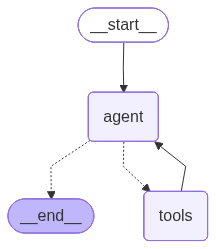

In [8]:
from deepagents import create_deep_agent

agent = create_deep_agent(
    sub_agent_tools,
    INSTRUCTIONS,
    subagents=[research_sub_agent],
    model=model,
)

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [9]:
result = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "Give me an very brief overview of Model Context Protocol (MCP).",
            }
        ],
    }
)

format_messages(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Give me an very brief overview of Model Context Protocol (MCP).                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ I'll help you get a brief overview of Model Context Protocol (MCP). Let me research this for you.               │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Research Model Context Protocol (MCP) to provide a brief overview",                           │
│       "status": "pending"                                                                                       │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: toolu_018cR751gLBpYbHR5qp7Gf9Y                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Research Model Context Protocol (MCP) to provide a brief overview',          │
│ 'status': 'pending'}]                                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: ls                                                                                                │
│    Args: {}                                                                                                     │
│    ID: toolu_01FihyQuqmG81J9DnQXxVG95                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_file                                                                                        │
│    Args: {                                                                                                      │
│   "file_path": "user_request.md",                                                                               │
│   "content": "# User Request\n\nGive me a very brief overview of Model Context Protocol (MCP).\n\n##            │
│ Requirements\n- Brief overview\n- Focus on key concepts and purpose"                                            │
│ }                                                                                                               │
│    ID: toolu_01GRrvNgigaxZnFT6teMwhwy                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated file user_request.md                                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Research Model Context Protocol (MCP) to provide a brief overview",                           │
│       "status": "in_progress"                                                                                   │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: toolu_015aSEwtnKsvWN5nLT1kd63N                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Research Model Context Protocol (MCP) to provide a brief overview',          │
│ 'status': 'in_progress'}]                                                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: task                                                                                              │
│    Args: {                                                                                                      │
│   "description": "Research Model Context Protocol (MCP) and provide a comprehensive overview covering: what it  │
│ is, its purpose, key features, how it works, who developed it, and its main use cases. Focus on providing       │
│ clear, factual information about this protocol.",                                                               │
│   "subagent_type": "research-agent"                                                                             │
│ }                                                                                                               │
│    ID: toolu_019bKa7VGa67rPvtU7BhYkMg                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Based on my research, here's a comprehensive overview of the Model Context Protocol (MCP):                      │
│                                                                                                                 │
│ ## What is the Model Context Protocol (MCP)?                                                                    │
│                                                                                                                 │
│ The Model Context Protocol (MCP) is a **standardized, open-source integration layer** designed to enhance       │
│ communication between AI applications (particularly large language models) and external tools, databases, or    │
│ templates. Think of it as a "USB-C port" for AI connectivity - it provides a universal standard that allows     │
│ different AI systems to seamlessly connect with various external resources.                                     │
│                                                                                                                 │
│ ## Developer                                                                                                    │
│                                                                                                                 │
│ MCP was **developed by Anthropic**, the company behind the Claude AI assistant. It's released as an open-source │
│ protocol, making it available for widespread adoption across the AI development community.                      │
│                                                                                                                 │
│ ## Purpose                                                                                                      │
│                                                                                                                 │
│ The primary purpose of MCP is to **address common challenges in AI tool integration** by:                       │
│ - Enabling AI agents to be context-aware                                                                        │
│ - Streamlining tool usage and data access                                                                       │
│ - Reducing development overhead when integrating AI with external systems                                       │
│ - Establishing a shared protocol standard for AI-tool interactions                                              │
│ - Improving overall AI model performance through better tool integration                                        │
│                                                                                                                 │
│ ## Key Features                                                                                                 │
│                                                                                                                 │
│ 1. **Modular Client-Server Architecture**: MCP uses a structured client-server model that separates concerns    │
│ and allows for flexible deployment                                                                              │
│ 2. **Enhanced Security**: Built-in security features to protect data and ensure safe interactions               │
│ 3. **Standardized Communication**: Uses JSON-RPC as the communication layer for structured, reliable            │
│ interactions                                                                                                    │
│ 4. **Flexibility**: Supports integration with diverse data sources and tools regardless of implementation       │
│ variations                                                                                                      │
│ 5. **Transport Medium Independence**: Can operate over different transport mediums, providing operational       │
│ flexibility                                            

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Research Model Context Protocol (MCP) to provide a brief overview",                           │
│       "status": "completed"                                                                                     │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: toolu_01MTtPBbSBeKEE6qTbwguSZK                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Research Model Context Protocol (MCP) to provide a brief overview',          │
│ 'status': 'completed'}]                                                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ ## Brief Overview of Model Context Protocol (MCP)                                                               │
│                                                                                                                 │
│ **Model Context Protocol (MCP)** is an open-source standardized integration layer developed by **Anthropic**    │
│ that acts like a "USB-C port" for AI connectivity.                                                              │
│                                                                                                                 │
│ **Key Points:**                                                                                                 │
│ - **Purpose**: Enables seamless communication between AI applications (like LLMs) and external tools,           │
│ databases, and data sources                                                                                     │
│ - **Architecture**: Uses a client-server model with JSON-RPC communication                                      │
│ - **Benefits**: Reduces development overhead, improves AI capabilities through better tool access, and provides │
│ standardized integration                                                                                        │
│ - **Use Cases**: Software development tool integration, data analysis, and building context-aware AI            │
│ applications                                                                                                    │
│                                                                                                                 │
│ Think of MCP as the universal standard that allows AI models to easily "plug into" various external resources   │
│ and tools, making them more capable and context-aware without requiring custom integrations for each            │
│ connection.                                                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Trace: 
https://smith.langchain.com/public/1d626d81-a102-4588-a2fb-cab40a7271f1/r
<!-- https://smith.langchain.com/public/1ae2d7f6-f901-4ebd-b6c3-6657a55f88ae/r -->

In [10]:
result["files"]

{'user_request.md': '# User Request\n\nGive me a very brief overview of Model Context Protocol (MCP).\n\n## Requirements\n- Brief overview\n- Focus on key concepts and purpose',
 'mcp_protocol_overview_CcUio5oG.md': '# Search Result: What is Model Context Protocol (MCP)? - IBM\n\n**URL:** https://www.ibm.com/think/topics/model-context-protocol\n**Query:** Model Context Protocol MCP what is purpose features developer\n**Date:** Mon Sep 29, 2025\n\n## Summary\nThe Model Context Protocol (MCP) is a standardized integration layer designed to enhance communication between AI applications and external tools, databases, or templates. It addresses the common challenges of tool integration in AI systems by allowing AI agents to be context-aware and streamline tool usage, similar to how a USB-C port facilitates hardware connectivity. Notably, MCP supports efficient data exchange, reducing development overhead and improving AI model performance, while establishing a shared protocol to optimize in

In [11]:
result["todos"]

[{'content': 'Research Model Context Protocol (MCP) to provide a brief overview',
  'status': 'completed'}]